#Food 101 10% Data

Our goal is to beat the original food101 original paper (ie., 50.76% accuracy)

In [1]:
!nvidia-smi

Sun Sep  5 10:32:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Let's download our helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-05 10:32:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-05 10:32:22 (59.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data,walk_through_dir

##Let's download the Data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

--2021-09-05 10:32:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   141MB/s    in 11s     

2021-09-05 10:32:35 (143 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")
test_dir="101_food_classes_10_percent/test/"

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10

In [6]:
#Setup data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #Let's keep test data in order

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take
* Create a ModelCheckpoint callback 
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-Model
* Compile our model
* Feature extract on 5 full passes(5 epochs on train data and validation on 15% test data, since too much test data )

In [7]:
#Create a Checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup Data Augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomRotation(0.2),
],name="data_augmentation")

In [9]:
#Setup the base model and freeze its layers 
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SIZE + (3,),name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
#Compile and Fit
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_101_0 = model.fit(train_data_all_10_percent,
                          epochs=5,steps_per_epoch=len(train_data_all_10_percent),
                          validation_data=test_data,
                          validation_steps=int(0.15*len(test_data)),
                          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 155s 508ms/step - loss: 3.4761 - accuracy: 0.2438 - val_loss: 2.6599 - val_accuracy: 0.3983
Epoch 2/5
237/237 [==============================] - 96s 406ms/step - loss: 2.3684 - accuracy: 0.4491 - val_loss: 2.2768 - val_accuracy: 0.4391
Epoch 3/5
237/237 [==============================] - 87s 367ms/step - loss: 2.0098 - accuracy: 0.5167 - val_loss: 2.0746 - val_accuracy: 0.4780
Epoch 4/5
237/237 [==============================] - 80s 336ms/step - loss: 1.7964 - accuracy: 0.5625 - val_loss: 2.0379 - val_accuracy: 0.4778
Epoch 5/5
237/237 [==============================] - 78s 328ms/step - loss: 1.6435 - accuracy: 0.5955 - val_loss: 1.9571 - val_accuracy: 0.4910


In [12]:
#Let's evaluate on whole test_data
feature_extraction_results = model.evaluate(test_data) #Beat the paper 54.2%

790/790 [==============================] - 103s 131ms/step - loss: 1.7316 - accuracy: 0.5461


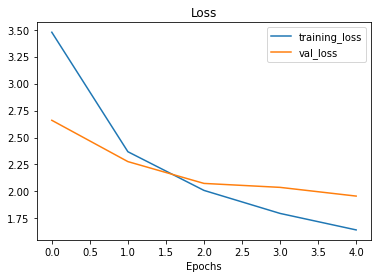

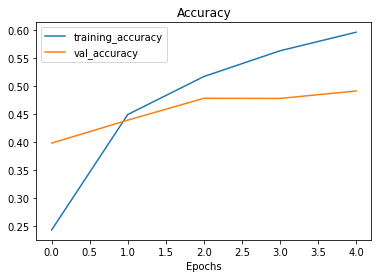

In [13]:
plot_loss_curves(history_101_0)

A hint of Over-Fitting

##Let's do some Fine-Tuning

In [14]:
#Unfreeze all of the layers in base model
base_model.trainable = True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 910,821
Non-trainable params: 3,268,131
_________________________________________________________________


In [16]:
#Recompile model with lower learning rate by atleast 10x
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [17]:
history_101_1 = model.fit(train_data_all_10_percent,
                          epochs=10,validation_data=test_data,
                          validation_steps=int(0.15*len(test_data)),
                          initial_epoch=history_101_0.epoch[-1],
                          callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 84s 319ms/step - loss: 1.4051 - accuracy: 0.6370 - val_loss: 1.9561 - val_accuracy: 0.4913
Epoch 6/10
237/237 [==============================] - 71s 297ms/step - loss: 1.2648 - accuracy: 0.6672 - val_loss: 1.9435 - val_accuracy: 0.4931
Epoch 7/10
237/237 [==============================] - 70s 293ms/step - loss: 1.1926 - accuracy: 0.6848 - val_loss: 1.9408 - val_accuracy: 0.4995
Epoch 8/10
237/237 [==============================] - 70s 291ms/step - loss: 1.1130 - accuracy: 0.7056 - val_loss: 1.9350 - val_accuracy: 0.5016
Epoch 9/10
237/237 [==============================] - 66s 276ms/step - loss: 1.0629 - accuracy: 0.7127 - val_loss: 1.9181 - val_accuracy: 0.5072
Epoch 10/10
237/237 [==============================] - 65s 271ms/step - loss: 1.0348 - accuracy: 0.7228 - val_loss: 1.9016 - val_accuracy: 0.5146


In [18]:
model_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 103s 130ms/step - loss: 1.6282 - accuracy: 0.5711


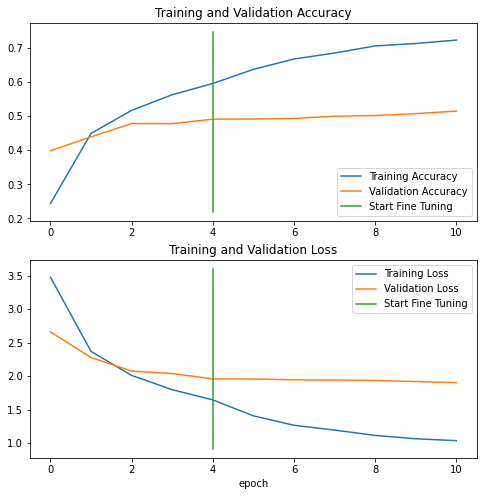

In [19]:
from helper_functions import compare_historys
compare_historys(history_101_0,history_101_1,initial_epochs=5)

In [20]:
#Maaking Predictions with our trained model
pred_probs = model.predict(test_data,verbose=1) 

790/790 [==============================] - 92s 114ms/step


In [21]:
pred_probs.shape

(25250, 101)

In [22]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  0,  0])

In [23]:
#To get our test labels we need to unravel our test_data BatchDataSet
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#Evaluating our Model's Predictions
One way to check that our model's preditions array is in the same order as our test labels array is to find accuracy score

In [24]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.5711287128712871

In [25]:
tf.experimental.numpy.isclose(sklearn_accuracy,model_fine_tune_results[1])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

##Let's plot all of our classes F1-scores...

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,pred_classes)) 

              precision    recall  f1-score   support

           0       0.31      0.14      0.20       250
           1       0.43      0.76      0.55       250
           2       0.76      0.51      0.61       250
           3       0.84      0.54      0.66       250
           4       0.49      0.44      0.47       250
           5       0.47      0.34      0.40       250
           6       0.76      0.72      0.74       250
           7       0.85      0.63      0.72       250
           8       0.20      0.63      0.31       250
           9       0.44      0.57      0.50       250
          10       0.45      0.43      0.44       250
          11       0.76      0.58      0.66       250
          12       0.75      0.56      0.64       250
          13       0.63      0.45      0.53       250
          14       0.54      0.43      0.48       250
          15       0.50      0.21      0.29       250
          16       0.60      0.59      0.59       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand. Let's visualize to understand better

In [27]:
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.19672131147540986,
  'precision': 0.3103448275862069,
  'recall': 0.144,
  'support': 250},
 '1': {'f1-score': 0.5483405483405482,
  'precision': 0.4288939051918736,
  'recall': 0.76,
  'support': 250},
 '10': {'f1-score': 0.43902439024390244,
  'precision': 0.4462809917355372,
  'recall': 0.432,
  'support': 250},
 '100': {'f1-score': 0.6408602150537634,
  'precision': 0.6930232558139535,
  'recall': 0.596,
  'support': 250},
 '11': {'f1-score': 0.6606334841628959,
  'precision': 0.7604166666666666,
  'recall': 0.584,
  'support': 250},
 '12': {'f1-score': 0.6422018348623854,
  'precision': 0.7526881720430108,
  'recall': 0.56,
  'support': 250},
 '13': {'f1-score': 0.5280373831775701,
  'precision': 0.6348314606741573,
  'recall': 0.452,
  'support': 250},
 '14': {'f1-score': 0.47893569844789363,
  'precision': 0.5373134328358209,
  'recall': 0.432,
  'support': 250},
 '15': {'f1-score': 0.2937853107344633,
  'precision': 0.5,
  'recall': 0.208,
  'support': 250}

#Let's plot all of our classes F1-scores...

In [28]:
#Create empty dictionary
class_f1_scores = {}
#Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    #Add class names and f1-scores to new dictionary
    class_f1_scores[test_data.class_names[int(k)]]=v["f1-score"]
class_f1_scores

{'apple_pie': 0.19672131147540986,
 'baby_back_ribs': 0.5483405483405482,
 'baklava': 0.6124401913875599,
 'beef_carpaccio': 0.6585365853658537,
 'beef_tartare': 0.46540880503144655,
 'beet_salad': 0.39631336405529954,
 'beignets': 0.7396694214876033,
 'bibimbap': 0.7218390804597701,
 'bread_pudding': 0.30829268292682926,
 'breakfast_burrito': 0.4973730297723292,
 'bruschetta': 0.43902439024390244,
 'caesar_salad': 0.6606334841628959,
 'cannoli': 0.6422018348623854,
 'caprese_salad': 0.5280373831775701,
 'carrot_cake': 0.47893569844789363,
 'ceviche': 0.2937853107344633,
 'cheese_plate': 0.5939393939393939,
 'cheesecake': 0.40290381125226854,
 'chicken_curry': 0.4595744680851064,
 'chicken_quesadilla': 0.5843230403800475,
 'chicken_wings': 0.7023172905525847,
 'chocolate_cake': 0.4426877470355731,
 'chocolate_mousse': 0.3013100436681223,
 'churros': 0.7106382978723405,
 'clam_chowder': 0.6694560669456067,
 'club_sandwich': 0.6417582417582418,
 'crab_cakes': 0.3469879518072289,
 'creme_

In [29]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.936660
63,macarons,0.829493
91,spaghetti_carbonara,0.829175
75,pho,0.820416
86,sashimi,0.814259
...,...,...
22,chocolate_mousse,0.301310
93,steak,0.298569
15,ceviche,0.293785
39,foie_gras,0.249275


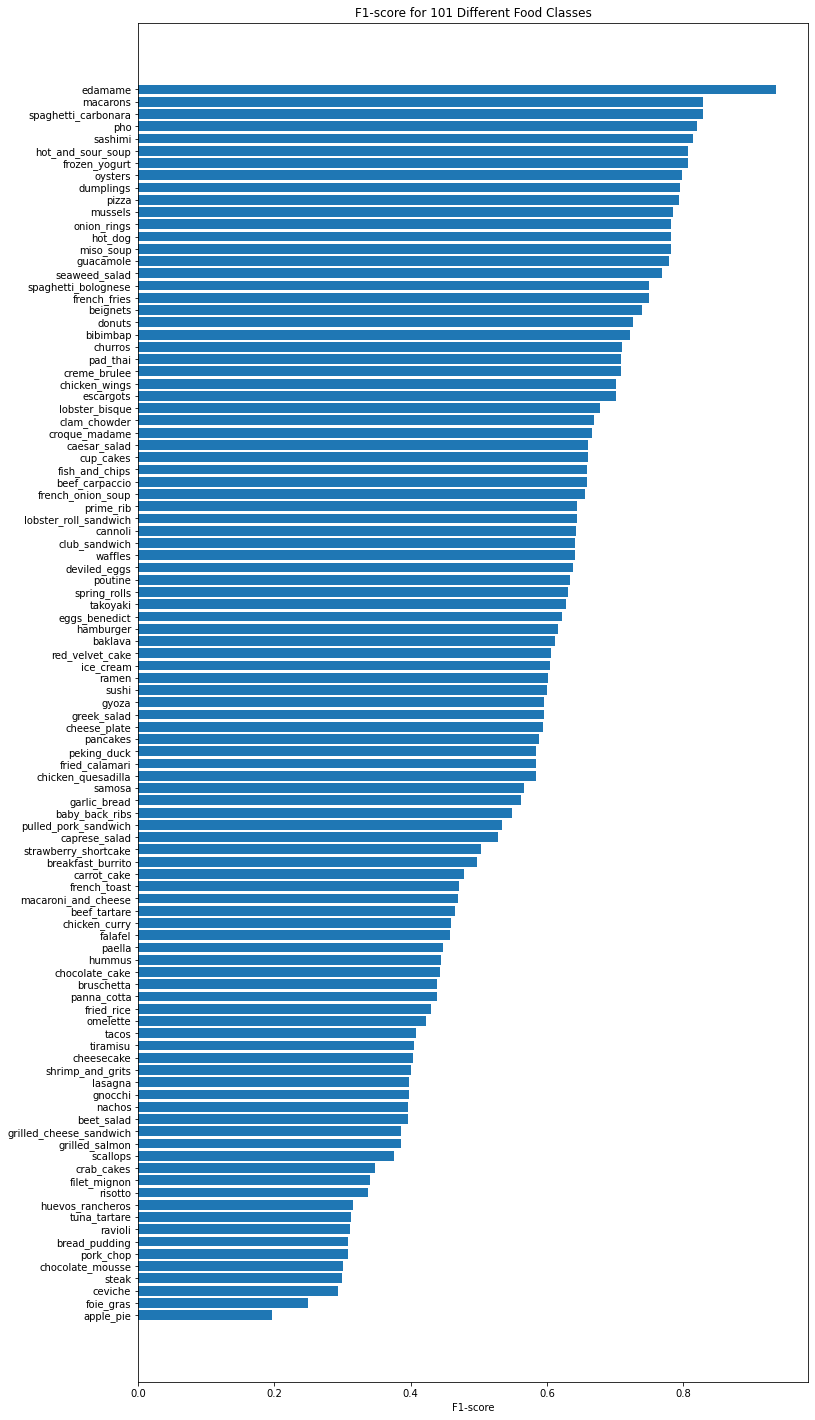

In [30]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"])
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 Different Food Classes")
ax.invert_yaxis()

Our model is performing poorly on apple_pie, foie_gras etc., images

##Visualizing predictions on custom images
Now, this is the real test, how does our model go on food images that are not in our test dataset.

Let's create a funnction to visualize our model's predictions, load and preprocess, specifically:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1

In [31]:
#Create a function to load and prepare images
def load_and_prep(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into tensor and reshapes into specified shape(img_shape, img_shape, 3)

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimensions of the target image size
    scale(bool): Rescale image or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  #Red in the image
  img = tf.io.read_file(filename)
  #Decode the image
  img = tf.io.decode_image(img,channels=3)
  #Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  #Scale? Yes/No
  if scale:
    return img/255.
  else:
    return img

Now, we've got a function to load and prepare target images, let's now write some code to visualize images, their target variabble and our model's preictions

<Figure size 1224x720 with 0 Axes>

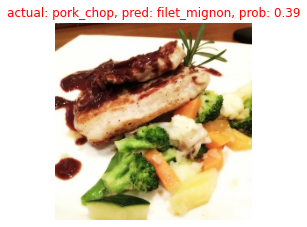

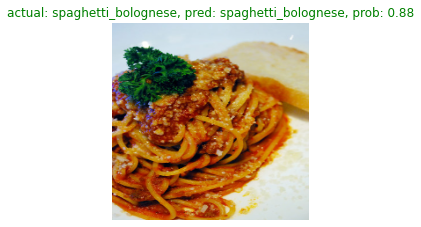

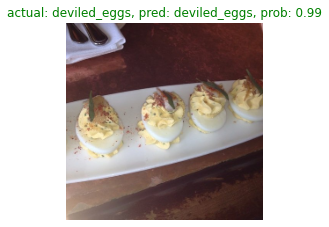

In [71]:
import random
import os

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath=test_dir+"/"+class_name+"/"+filename

  #Load the image and make predictions
  img = load_and_prep(filepath,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  #print(class_name)
  #print(pred_prob)
  #print(pred_class)

  #plot the images
  plt.figure(figsize=(12,24))
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name==pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}",c=title_color)
  plt.axis(False)

##Finding the most wrong predictions (ie., the model is highly confident but predicted wrong)

We'll go through the following steps:
* Get all the image file paths in the test dataseet using list_files() method
* Create a pandas DataFrame of the image Filepaths, ground truth labels, predicted classes, macx prediction probabilities
* Use our DataFrame to find all the wron predictions
* Sort the DataFrame based on wrong predictions (have the highest probability on top)
* Visualize the images which have the wrong predictions

In [63]:
#1. Get all of the image filepaths in the test dataset
filepaths= []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [67]:
#2. Create a DataFrame of different parameters for each of our images
import pandas as pd
pred_df=pd.DataFrame({"img_path": filepaths,
                      "y_true":y_labels,
                      "y_pred":pred_classes,
                      "pred_conf": pred_probs.max(axis=1),
                      "y_true_classname":[class_names[i] for i in y_labels],
                      "y_pred_classname":[class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.367062,apple_pie,apple_pie
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.813019,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.175395,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.231094,apple_pie,bread_pudding
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.257853,apple_pie,bread_pudding
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.887493,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.913201,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.355889,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.245633,waffles,waffles


In [70]:
#3. Find out in our DataFrame which predictions were wrong

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.367062,apple_pie,apple_pie,True
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.813019,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.175395,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.231094,apple_pie,bread_pudding,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.257853,apple_pie,bread_pudding,False
5,b'/content/101_food_classes_10_percent/test/ap...,0,78,0.982059,apple_pie,poutine,False
6,b'/content/101_food_classes_10_percent/test/ap...,0,29,0.899807,apple_pie,cup_cakes,False
7,b'/content/101_food_classes_10_percent/test/ap...,0,46,0.487276,apple_pie,garlic_bread,False
8,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.260585,apple_pie,apple_pie,True
9,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.548420,apple_pie,apple_pie,True


In [72]:
#4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending = False)[:100]
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23631,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999377,strawberry_shortcake,red_velvet_cake,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.998300,sushi,sashimi,False
11642,b'/content/101_food_classes_10_percent/test/ga...,46,10,0.995562,garlic_bread,bruschetta,False
10847,b'/content/101_food_classes_10_percent/test/fr...,43,68,0.994646,fried_calamari,onion_rings,False
305,b'/content/101_food_classes_10_percent/test/ba...,1,8,0.994216,baby_back_ribs,bread_pudding,False
...,...,...,...,...,...,...,...
24740,b'/content/101_food_classes_10_percent/test/ti...,98,27,0.964730,tiramisu,creme_brulee,False
5530,b'/content/101_food_classes_10_percent/test/ch...,22,60,0.964213,chocolate_mousse,lobster_bisque,False
14997,b'/content/101_food_classes_10_percent/test/la...,59,41,0.963378,lasagna,french_onion_soup,False
5612,b'/content/101_food_classes_10_percent/test/ch...,22,21,0.963365,chocolate_mousse,chocolate_cake,False


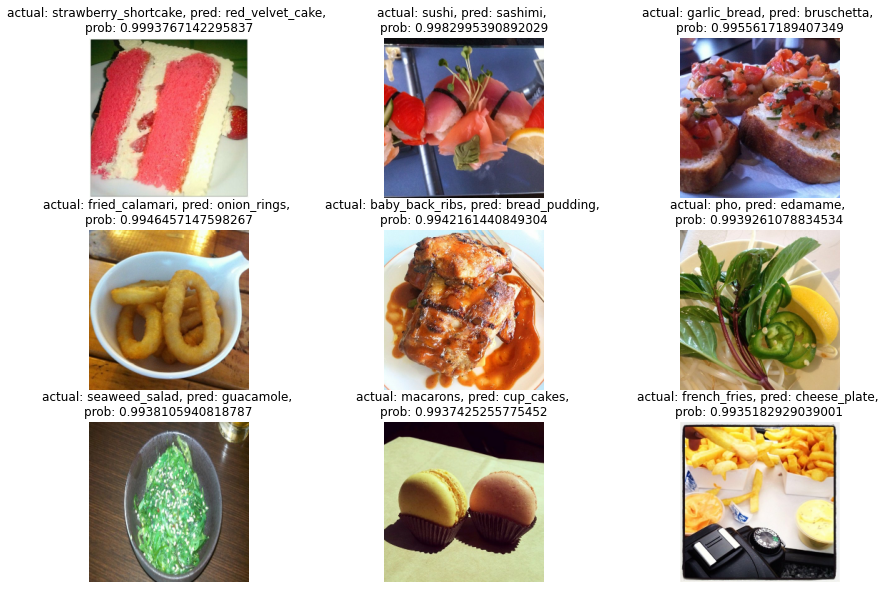

In [83]:
#5. Visualize the data samples that are wrong and have high pred_conf
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep(row[1], scale=False)
  _,_,_,_,pred_prob, y_true_classname, y_pred_classname,_=row #only interested in a few parameters
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False) 